In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
cd ./drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/

[Errno 2] No such file or directory: './drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/'
/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments


In [48]:
!ls

checkpoints					lightning_logs
Connexus_load_forecasting_program_also.ipynb	load_weather_programs_df.csv
Connexus_load_forecasting_weather_only_2.ipynb	runs
Connexus_load_forecasting_weather_only.ipynb	Untitled0.ipynb


### Import packages and do some settings

In [6]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [8]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

### Load data

In [9]:
from google.colab import files
import io

uploaded = files.upload()

Saving load_weather_programs_df.csv to load_weather_programs_df.csv


In [24]:
df = pd.read_csv('./load_weather_programs_df.csv', parse_dates=['intervalStart'])
df.head()

,Unnamed: 0,intervalStart,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,cloudCover,dewPoint,...,windGust,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins
0,0,2017-01-01 01:00:00,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,18.93,0.39,19.23,...,10.51,5.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2017-01-01 02:00:00,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,20.16,0.00,18.98,...,8.88,4.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2017-01-01 03:00:00,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,20.40,0.04,18.58,...,6.34,3.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2017-01-01 04:00:00,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,24.46,0.20,18.62,...,5.83,2.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2017-01-01 05:00:00,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,23.61,0.11,18.69,...,3.13,1.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Define necessary classes or functions

In [49]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):

  sequences = []
  data_size = len(input_data)

  for i in  tqdm(range(data_size - sequence_length)):
    sequence = input_data[i:i+sequence_length]

    label_position = i + sequence_length
    label = input_data.iloc[label_position][target_column]


    sequences.append((sequence, label))

  return sequences


In [50]:
class CNXDataset(Dataset):

  def __init__(self, sequences):

    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence, label = self.sequences[index]

    return dict(
        sequence = torch.Tensor(sequence.to_numpy()),
        label = torch.tensor(label).float()
    )

In [51]:
class CNXLoadDataModule(pl.LightningDataModule):

  def __init__(self, train_sequences, test_sequences, batch_size=8):
    super().__init__()
    self.train_sequences = train_sequences
    self.test_sequences = test_sequences
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = CNXDataset(self.train_sequences)
    self.test_dataset = CNXDataset(self.test_sequences)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2)

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1)

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1)

In [52]:
class CNXLoadPredictionModel(nn.Module):

  def __init__(self, n_features, n_layers, dropout, n_hidden):
    super().__init__()
    self.n_hidden = n_hidden

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers,
        dropout = dropout,

    )


    self.regressor = nn.Linear(n_hidden, 1)

  def forward(self, x):

    self.lstm.flatten_parameters()

    _, (hidden, _) = self.lstm(x)
    out = hidden[-1]

    return self.regressor(out)


In [72]:
from torch.utils.tensorboard import SummaryWriter

train_writer = SummaryWriter(log_dir='./runs/train')
val_writer = SummaryWriter(log_dir='./runs/val')

In [73]:
from numpy.random.mtrand import noncentral_chisquare
class CNXLoadPredictor(pl.LightningModule):

  def __init__(self, n_features: int, n_layers: int, optimizer: str,
               optimizer_learning_rate: float, dropout: float, num_nodes: int):

    super().__init__()

    self.model = CNXLoadPredictionModel(n_features, n_layers, dropout, num_nodes)

    self.criterion = nn.MSELoss()


  def forward(self, x, labels = None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels.unsqueeze(dim=1))
    return loss, output

  def training_step(self, batch, batch_idx):

    sequences = batch['sequence']
    labels = batch['label']

    loss, outputs = self(sequences, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    train_writer.add_scalar('loss', loss, batch_idx)
    return loss

  def validation_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)
    val_writer.add_scalar('loss', loss, batch_idx)
    return loss

  def test_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    self.log(f'test_loss', loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):

    if optimizer == 'Adam':
      return optim.AdamW(self.parameters(), lr=optimizer_learning_rate)
    elif optimizer == 'Adadelta':
      return optim.Adadelta(self.parameters(), lr=optimizer_learning_rate)
    elif optimizer == 'Adamax':
      return optim.Adamax(self.parameters(), lr=optimizer_learning_rate)
    elif optimizer == 'Nadam':
      return optim.Nadam(self.parameters(), lr=optimizer_learning_rate)



In [74]:
def descale(descaler, values):
  values_2d = np.array(values)[:, np.newaxis]
  return descaler.inverse_transform(values_2d).flatten()

In [75]:
def make_model_input_data(df, seq_length, batch_size):

  df['prev_Connexus_kWh'] = df.shift(1)['Connexus_kWh']

  df['Connexus_kWh_change'] = df.progress_apply(
    lambda row : 0 if np.isnan(row.prev_Connexus_kWh) else (row.Connexus_kWh - row.prev_Connexus_kWh),
    axis=1)

  rows = []

  for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict()

    for column in df.columns:
      if column == 'intervalStart':
        row_data['day_of_week'] = row.intervalStart.dayofweek
        row_data['day_of_month'] = row.intervalStart.day
        row_data['week_of_year'] = row.intervalStart.week
        row_data['month'] = row.intervalStart.month

      else:
        if column!='prev_Connexus_kWh':
          row_data[str(column)] = row[str(column)]


    rows.append(row_data)

  features_df = pd.DataFrame(rows)

  features_df = features_df.drop(['Unnamed: 0'], axis=1)

  train_size = int(len(features_df)*0.9)

  train_df, test_df = features_df[:train_size], features_df[train_size+1:]


  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train_df)

  train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
  test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

  for i in train_df.columns:
    if '_mins' in i:
      train_df = train_df.drop(columns = [i])


  for i in test_df.columns:
    if '_mins' in i:
      test_df = test_df.drop(columns = [i])


  sequence_length = seq_length

  train_sequences = create_sequences(train_df, 'Connexus_kWh', sequence_length)
  test_sequences = create_sequences(test_df, 'Connexus_kWh', sequence_length)



  data_module = CNXLoadDataModule(train_sequences, test_sequences, batch_size=batch_size)
  data_module.setup()

  return features_df, train_df, train_sequences, test_df, test_sequences,  data_module, scaler

In [76]:
def run_LSTM(train_df, train_sequences, test_df, test_sequences, data_module, n_layers, num_epochs,
             optimizer, optimizer_learning_rate, dropout, num_nodes):

  model = CNXLoadPredictor(n_features = train_df.shape[1], n_layers=n_layers,
                           optimizer = optimizer, optimizer_learning_rate = optimizer_learning_rate,
                           dropout = dropout, num_nodes = num_nodes)

  checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
    )

  logger = TensorBoardLogger("lightning_logs", \
                             name="load_predictor")

  logger.log_hyperparams({'n_layers':n_layers, 'num_epochs':num_epochs})


  early_stopping_callback = EarlyStopping(
      monitor="val_loss", patience=2
  )

  trainer = pl.Trainer(
      logger = logger,
      callbacks = [early_stopping_callback, checkpoint_callback],
      max_epochs = num_epochs
  )

  trainer.fit(model, data_module)

  test_dataset = CNXDataset(test_sequences)

  predictions = []
  labels = []

  for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())


  return predictions, labels

In [77]:
def draw_result(features_df, predictions, labels, seq_length):
  descaler = MinMaxScaler()
  descaler.min_, descaler.scale_ = scaler.min_[4], scaler.scale_[4]

  predictions_descaled = descale(descaler, predictions)
  labels_descaled = descale(descaler, labels)

  train_size = int(len(features_df)*0.9)
  test_data = df[train_size + 1:]

  test_sequences_data = test_data.iloc[seq_length:]

  dates = matplotlib.dates.date2num(test_sequences_data[:100].intervalStart.tolist())
  plt.plot_date(dates, predictions_descaled[:100], "-", label="predicted")
  plt.plot_date(dates, labels_descaled[:100], "-", label="real")
  plt.xticks(rotation=45)
  plt.legend()
  plt.figure(figsize=(6, 3))
  plt.show()

###  Experiments

##### hyper parameters
- number of nodes
- number of hidden layers
- number of units in dense layer
- dropout
- weight initialization
- decay rate
- activation function
- optimizer

In [78]:
import itertools

seq_length_list = [100, 120]
num_layers_list = [1, 2]
optimizer = ['Adam']
optimizer_learning_rate = [0.0001]
dropout = [0.1]
num_nodes = [256]

total_list = [seq_length_list, num_layers_list, optimizer, optimizer_learning_rate, dropout, num_nodes]
param_sets = list(itertools.product(*total_list))

In [79]:
param_sets[:5]

[(100, 1, 'Adam', 0.0001, 0.1, 256),
 (100, 2, 'Adam', 0.0001, 0.1, 256),
 (120, 1, 'Adam', 0.0001, 0.1, 256),
 (120, 2, 'Adam', 0.0001, 0.1, 256)]

(100, 1, 'Adam', 0.0001, 0.1, 256)


  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/52670 [00:00<?, ?it/s]

  0%|          | 0/5763 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_V

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.03112 (best 0.03112), saving model to '/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints/best-checkpoint-v15.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.00979 (best 0.00979), saving model to '/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints/best-checkpoint-v15.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.00564 (best 0.00564), saving model to '/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints/best-checkpoint-v15.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


  0%|          | 0/5763 [00:00<?, ?it/s]

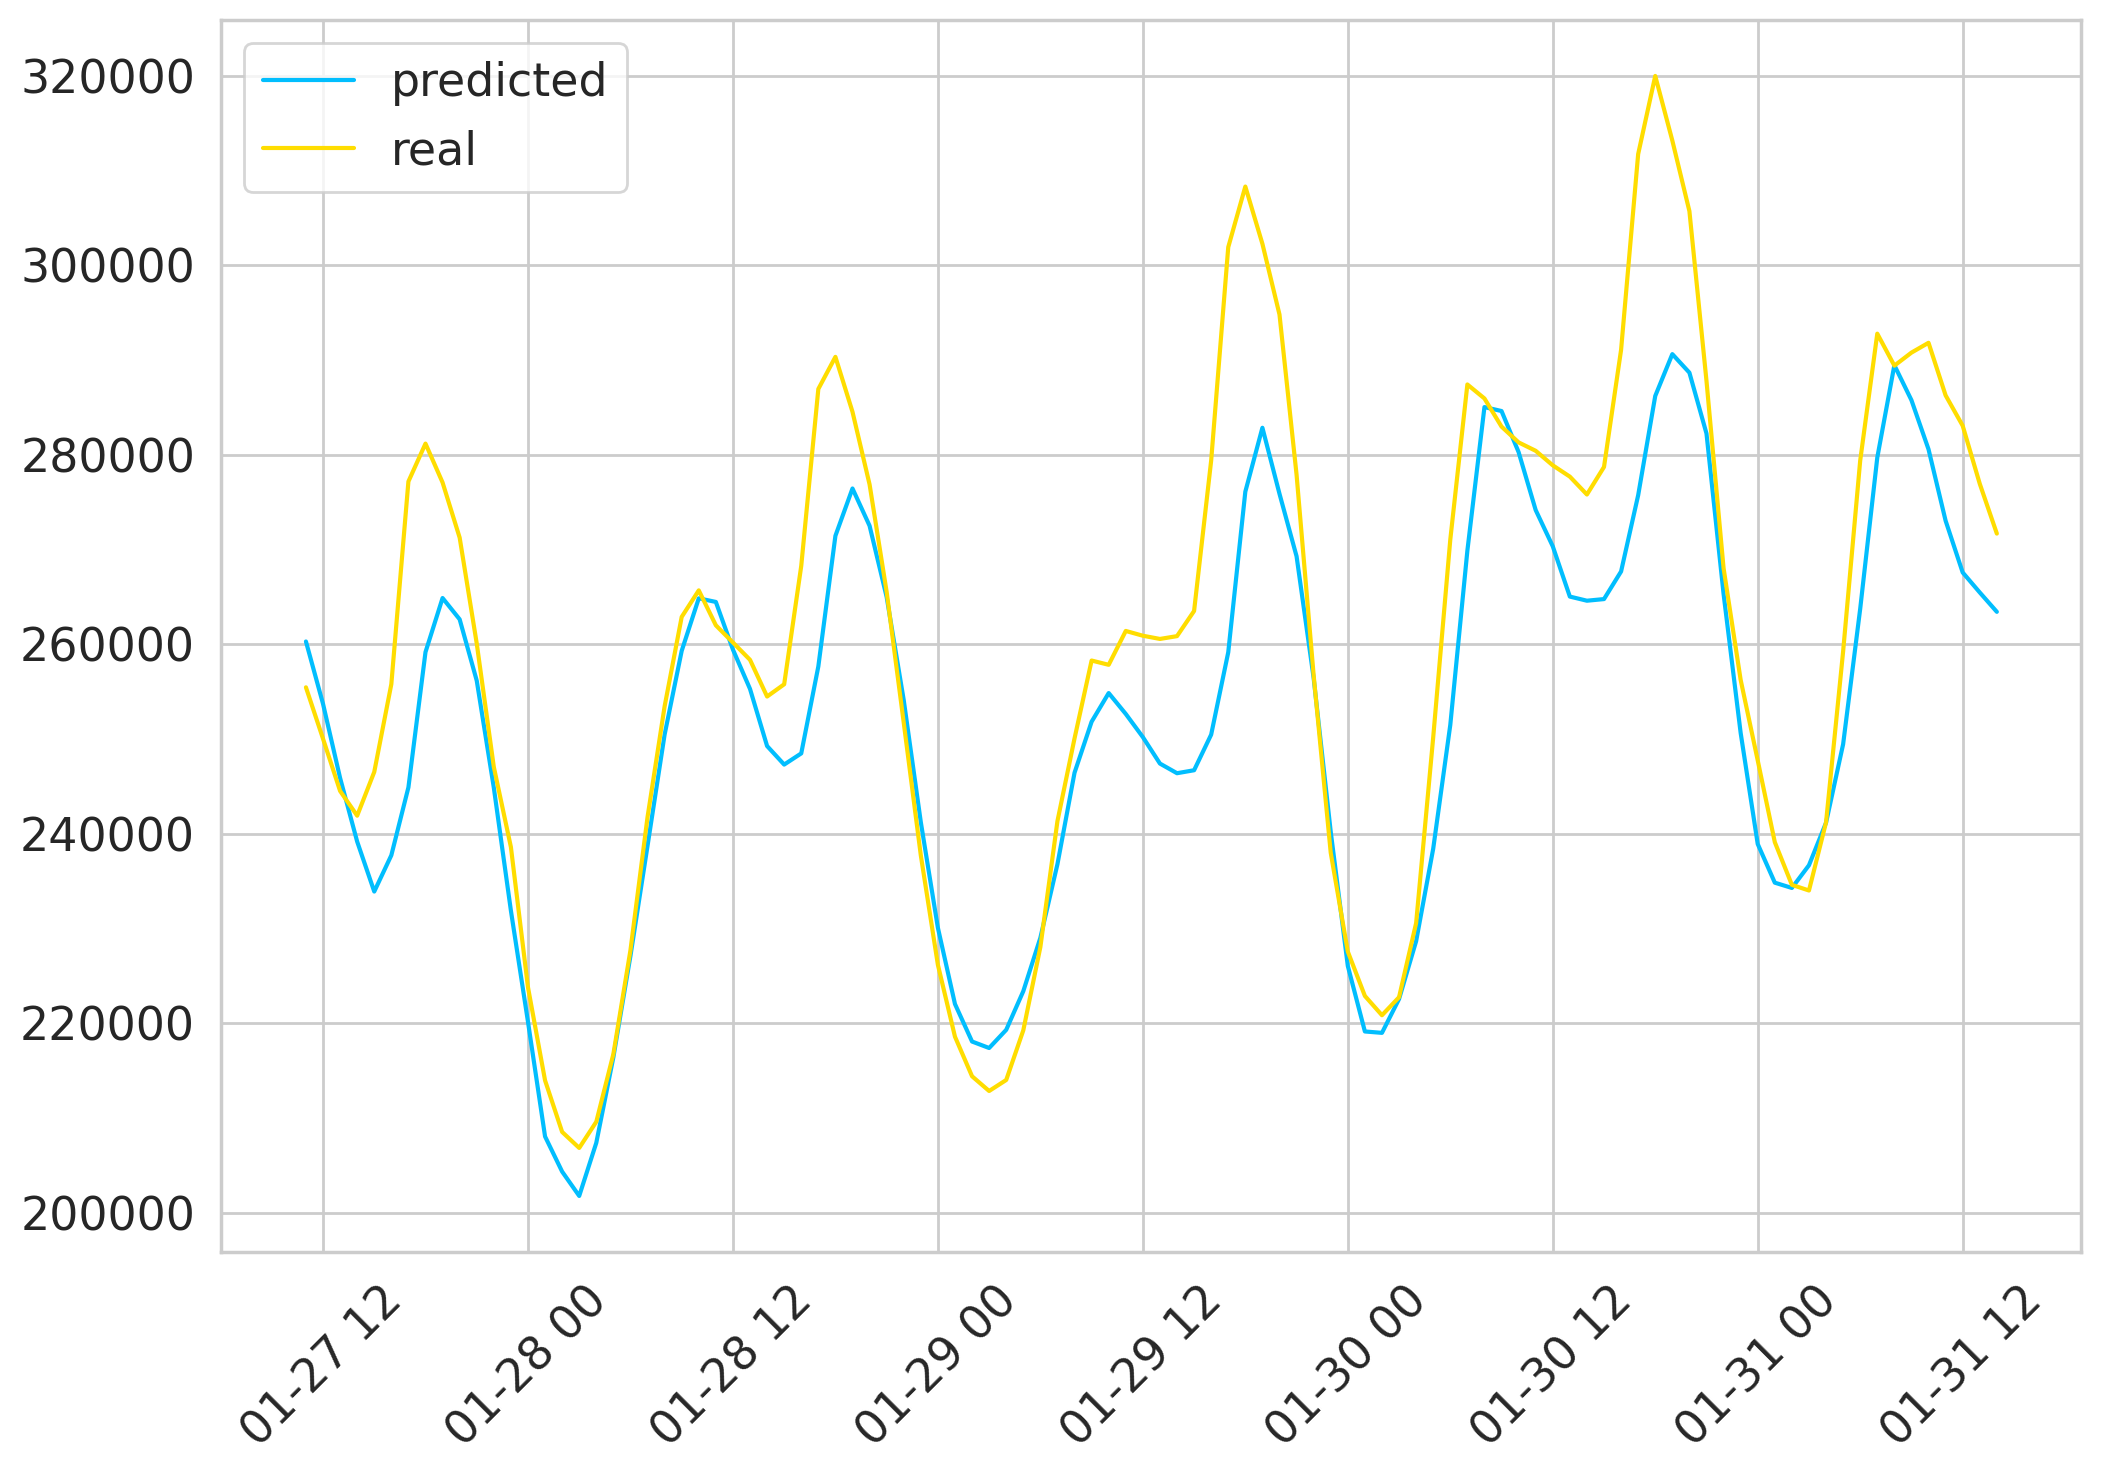

<Figure size 600x300 with 0 Axes>

(100, 2, 'Adam', 0.0001, 0.1, 256)


  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/52670 [00:00<?, ?it/s]

  0%|          | 0/5763 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | CNXLoadPredictionModel | 819 K 
1 | criterion | MSELoss                | 0     
-------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.04254 (best 0.04254), saving model to '/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints/best-checkpoint-v16.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.01515 (best 0.01515), saving model to '/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints/best-checkpoint-v16.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.00534 (best 0.00534), saving model to '/content/drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/checkpoints/best-checkpoint-v16.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


  0%|          | 0/5763 [00:00<?, ?it/s]

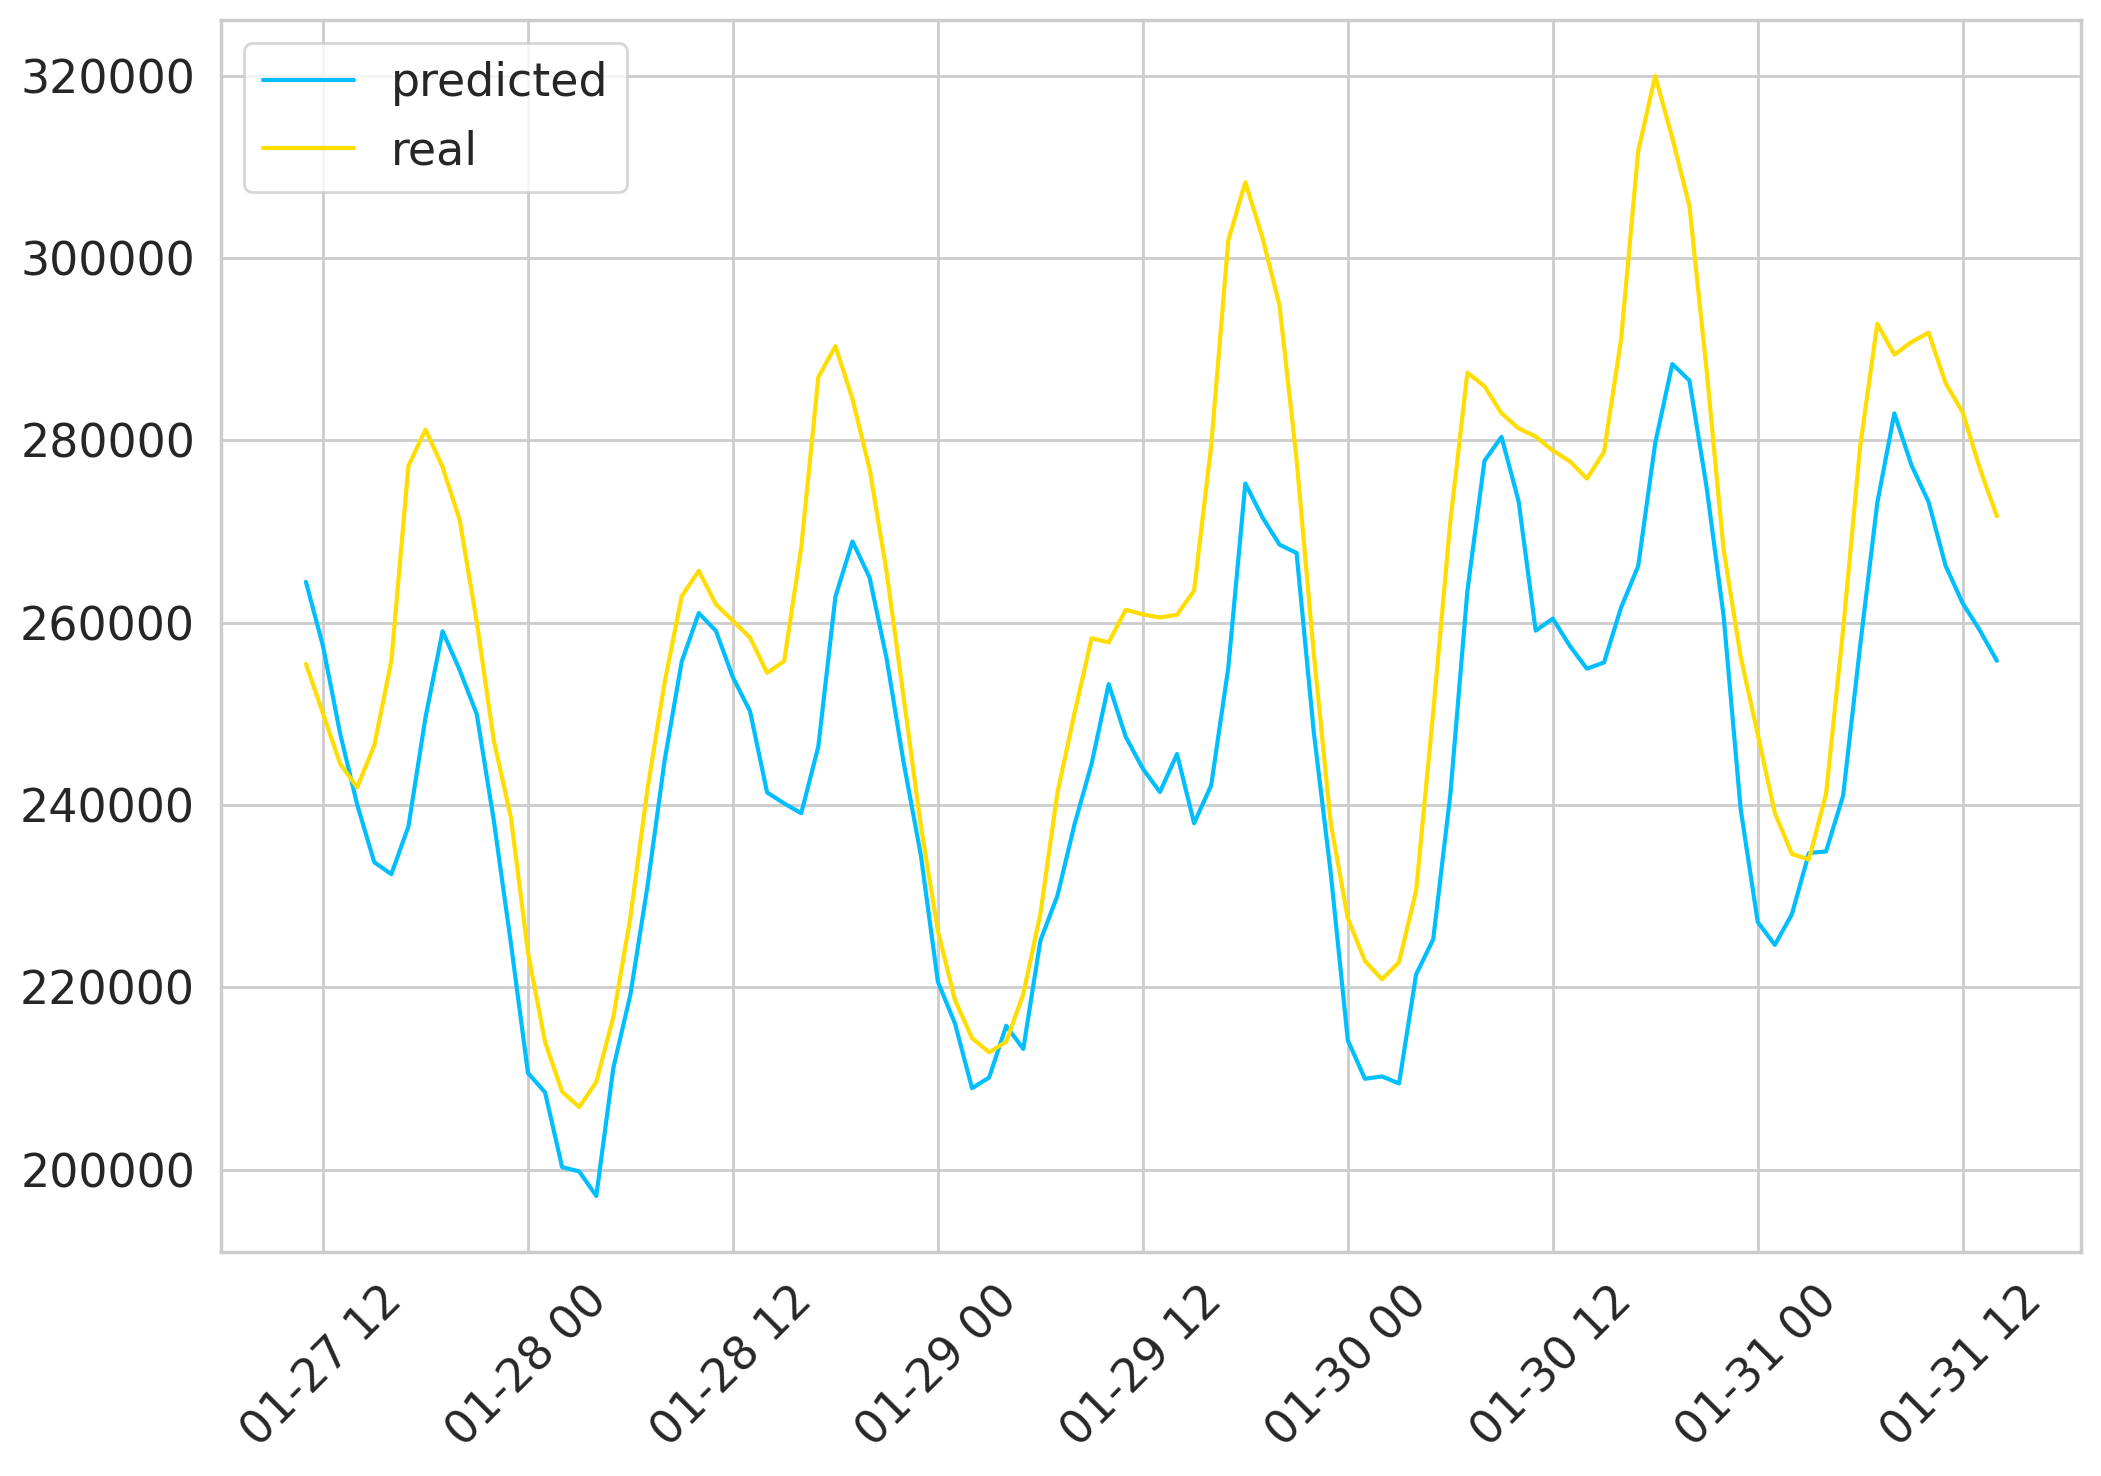

<Figure size 600x300 with 0 Axes>

In [80]:
for i in param_sets[:2]:

  print(i)

  seq_length = i[0]
  num_layers = i[1]
  optimizer = i[2]
  optimizer_learning_rate = i[3]
  dropout = i[4]
  num_nodes = i[5]


  features_df, train_df, train_sequence, test_df, test_sequence, data_module, scaler = \
  make_model_input_data(df=df, seq_length=seq_length, batch_size=64)

  predictions, labels = run_LSTM(
    train_df = train_df,
    train_sequences = train_sequence,
    test_df = test_df,
    test_sequences = test_sequence,
    data_module = data_module,
    n_layers = num_layers,
    num_epochs = 3,

    optimizer = optimizer,
    optimizer_learning_rate = optimizer_learning_rate,
    dropout = dropout,
    num_nodes = num_nodes
  )

  draw_result(features_df, predictions, labels, seq_length=seq_length)